In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datapackage import Package
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [2]:
package = Package('https://datahub.io/core/employment-us/datapackage.json')

print(package.resource_names)

for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        data = pd.read_csv(resource.raw_iter())
        print(data)
        #print(resource.read())

['validation_report', 'aat1_csv', 'aat1_json', 'employment-us_zip', 'aat1']
    year  population  labor_force  population_percent  employed_total  \
0   1941       99900        55910                56.0           50350   
1   1942       98640        56410                57.2           53750   
2   1943       94640        55540                58.7           54470   
3   1944       93220        54630                58.6           53960   
4   1945       94090        53860                57.2           52820   
..   ...         ...          ...                 ...             ...   
66  2006      228815       151428                66.2          144427   
67  2007      231867       153124                66.0          146047   
68  2008      233788       154287                66.0          145362   
69  2009      235801       154142                65.4          139877   
70  2010      237830       153889                64.7          139064   

    employed_percent  agrictulture_ratio  nonag

In [3]:
data.head()

,year,population,labor_force,population_percent,employed_total,employed_percent,agrictulture_ratio,nonagriculture_ratio,unemployed,unemployed_percent,not_in_labor,footnotes
0,1941,99900,55910,56.0,50350,50.4,9100,41250,5560,9.9,43990,NaN
1,1942,98640,56410,57.2,53750,54.5,9250,44500,2660,4.7,42230,NaN
2,1943,94640,55540,58.7,54470,57.6,9080,45390,1070,1.9,39100,NaN
3,1944,93220,54630,58.6,53960,57.9,8950,45010,670,1.2,38590,NaN
4,1945,94090,53860,57.2,52820,56.1,8580,44240,1040,1.9,40230,NaN


Immediately from the head of the data we can see a misspelling in the column 'agrictulture_ratio' which supposed to be 'agriculture_ratio'.

In [4]:
data.tail()

,year,population,labor_force,population_percent,employed_total,employed_percent,agrictulture_ratio,nonagriculture_ratio,unemployed,unemployed_percent,not_in_labor,footnotes
66,2006,228815,151428,66.2,144427,63.1,2206,142221,7001,4.6,77387,1.0
67,2007,231867,153124,66.0,146047,63.0,2095,143952,7078,4.6,78743,1.0
68,2008,233788,154287,66.0,145362,62.2,2168,143194,8924,5.8,79501,1.0
69,2009,235801,154142,65.4,139877,59.3,2103,137775,14265,9.3,81659,1.0
70,2010,237830,153889,64.7,139064,58.5,2206,136858,14825,9.6,83941,1.0


# Data Exploration

### Checking Data

Checking Shape of Data

In [5]:
data.shape

(71, 12)

Checking General Information of Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  71 non-null     int64  
 1   population            71 non-null     int64  
 2   labor_force           71 non-null     int64  
 3   population_percent    71 non-null     float64
 4   employed_total        71 non-null     int64  
 5   employed_percent      71 non-null     float64
 6   agrictulture_ratio    71 non-null     int64  
 7   nonagriculture_ratio  71 non-null     int64  
 8   unemployed            71 non-null     int64  
 9   unemployed_percent    71 non-null     float64
 10  not_in_labor          71 non-null     int64  
 11  footnotes             21 non-null     float64
dtypes: float64(4), int64(8)
memory usage: 6.8 KB


Checking General Statistic Information

In [7]:
data.describe()

,year,population,labor_force,population_percent,employed_total,employed_percent,agrictulture_ratio,nonagriculture_ratio,unemployed,unemployed_percent,not_in_labor,footnotes
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,21.0
mean,1975.098592,156272.521127,98707.492958,62.230986,93033.577465,58.773239,4456.492958,88577.028169,5673.774648,5.509859,57564.929577,1.0
std,20.486340,44979.642300,33380.727804,3.513793,30992.290437,3.140380,2055.547406,32739.727633,2954.030173,1.818803,11795.889143,0.0
min,1941.000000,93220.000000,53860.000000,55.800000,50350.000000,50.400000,2095.000000,41250.000000,670.000000,1.200000,38590.000000,1.0
25%,1957.500000,112996.000000,67284.000000,59.200000,63935.000000,56.400000,3235.000000,57818.500000,3131.500000,4.350000,45969.000000,1.0
50%,1975.000000,153153.000000,93774.000000,61.300000,86794.000000,57.800000,3440.000000,83279.000000,5692.000000,5.500000,59377.000000,1.0
75%,1992.500000,193821.500000,128652.500000,66.000000,119526.000000,61.950000,5766.500000,116357.000000,7614.000000,6.450000,65169.000000,1.0
max,2010.000000,237830.000000,154287.000000,67.100000,146047.000000,64.400000,9250.000000,143952.000000,14825.000000,9.900000,83941.000000,1.0


Check Missing Value

In [8]:
data.isnull().sum()

year                     0
population               0
labor_force              0
population_percent       0
employed_total           0
employed_percent         0
agrictulture_ratio       0
nonagriculture_ratio     0
unemployed               0
unemployed_percent       0
not_in_labor             0
footnotes               50
dtype: int64

Checking Variable Coorelation

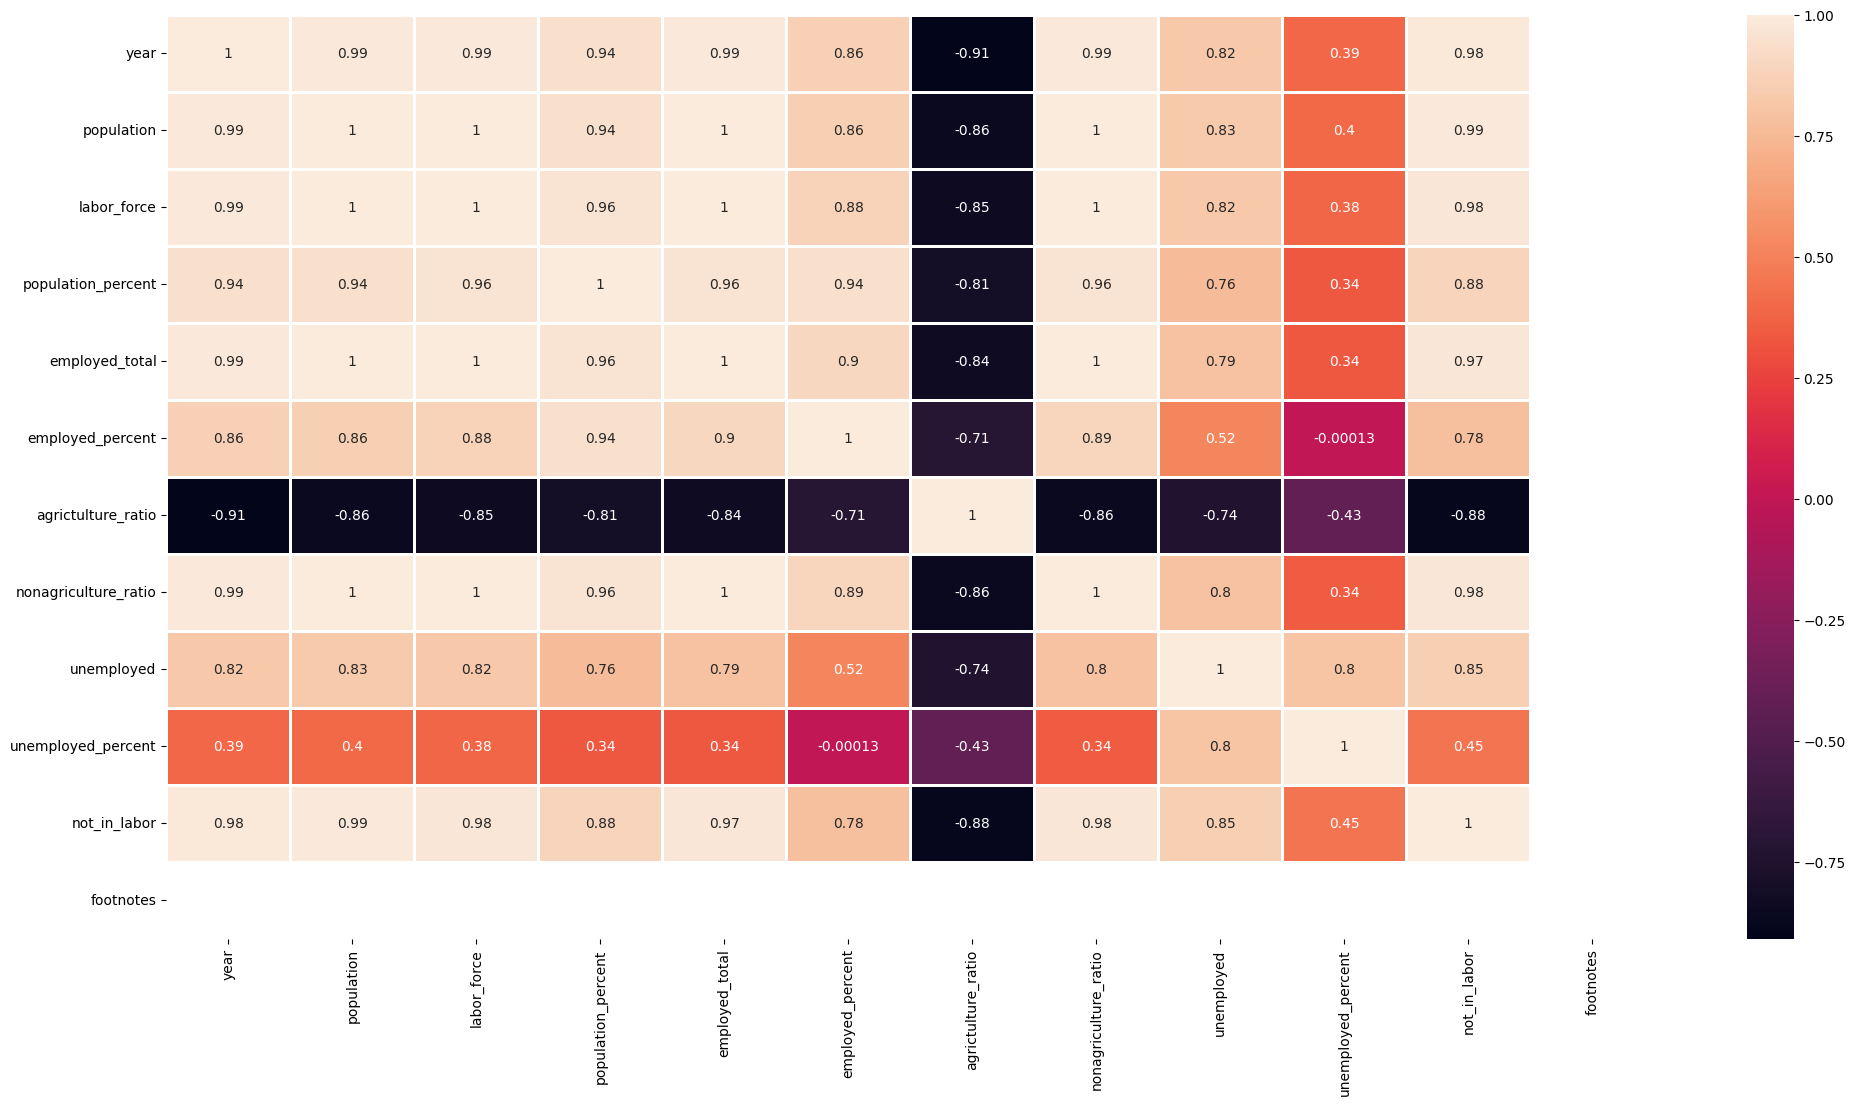

In [9]:
plt.figure(figsize=(24,12))
corr = data.corr()
sns.heatmap(corr, annot = True, linewidths=1)
plt.show()

Based on the correlation map above, we can notice that the year variable has high correlation with almost all the data except for the unemployed_percent with correlation as low as 0.39 and agriculture_ratio which shows little to no correlation even showing a negative correlation  with almost all the variables within the data. This shows us that population, employment rate (based on employed_total and employed_percent)  has been increasing throughout the year, but we can't say the same on the unemployed_percent which shows a weak correlation.

Checking Data Type

In [10]:
data.dtypes

year                      int64
population                int64
labor_force               int64
population_percent      float64
employed_total            int64
employed_percent        float64
agrictulture_ratio        int64
nonagriculture_ratio      int64
unemployed                int64
unemployed_percent      float64
not_in_labor              int64
footnotes               float64
dtype: object

## Univariate Analysis

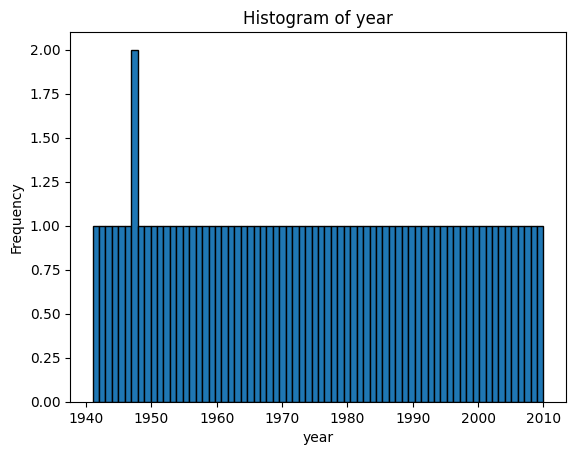

In [11]:
column_to_analyze = 'year'
plt.hist(data[column_to_analyze], bins=70, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

Here we can see that the year there are 2 records with the year 1947.


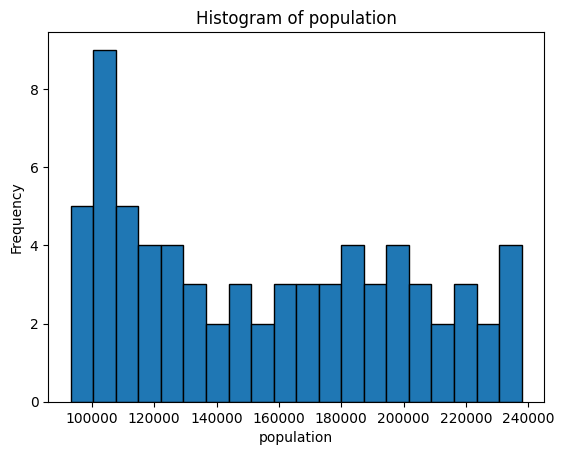

In [12]:
column_to_analyze = 'population'
plt.hist(data[column_to_analyze], bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

The chart for population shows a right skewed histogram where there is a abundance of record with population of around 110000

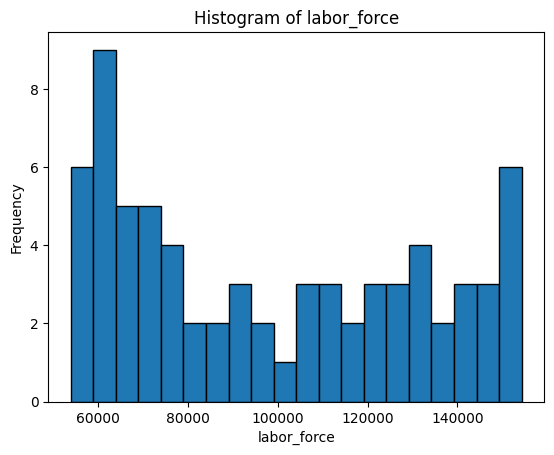

In [13]:
column_to_analyze = 'labor_force'
plt.hist(data[column_to_analyze], bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

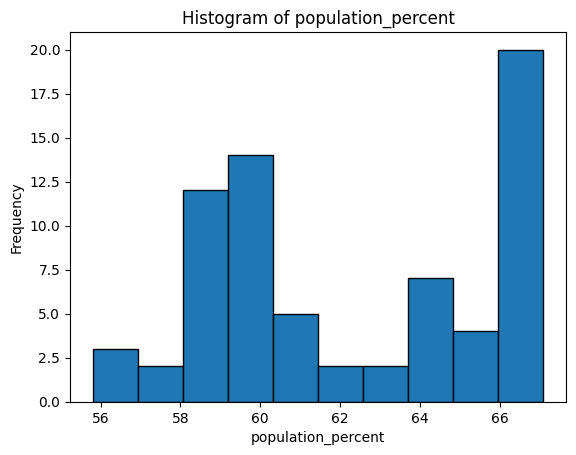

In [14]:
column_to_analyze = 'population_percent'
plt.hist(data[column_to_analyze], bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

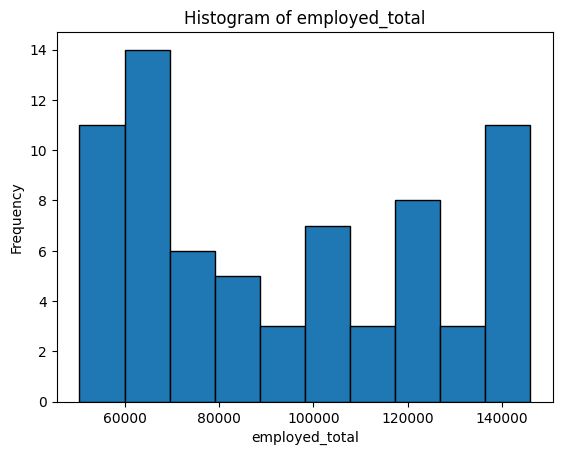

In [15]:
column_to_analyze = 'employed_total'
plt.hist(data[column_to_analyze], bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

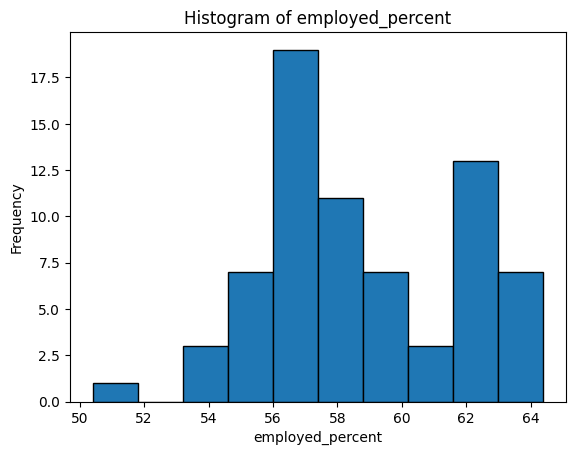

In [16]:
column_to_analyze = 'employed_percent'
plt.hist(data[column_to_analyze], bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

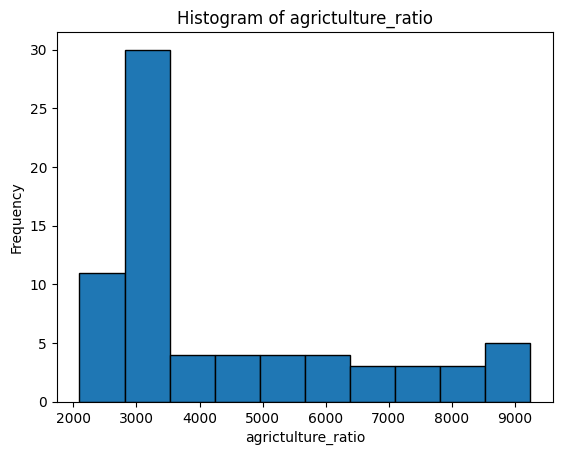

In [17]:
column_to_analyze = 'agrictulture_ratio'
plt.hist(data[column_to_analyze], bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

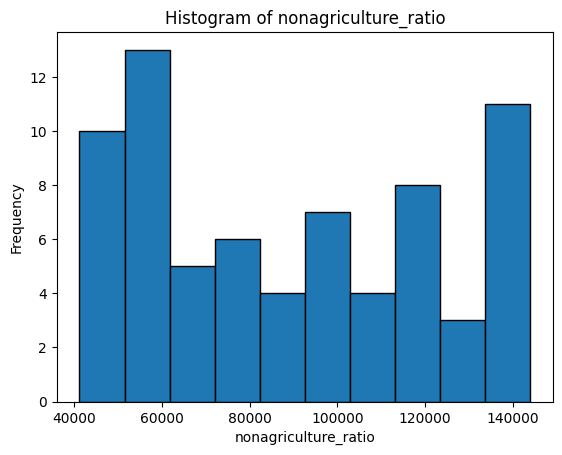

In [18]:
column_to_analyze = 'nonagriculture_ratio'
plt.hist(data[column_to_analyze], bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

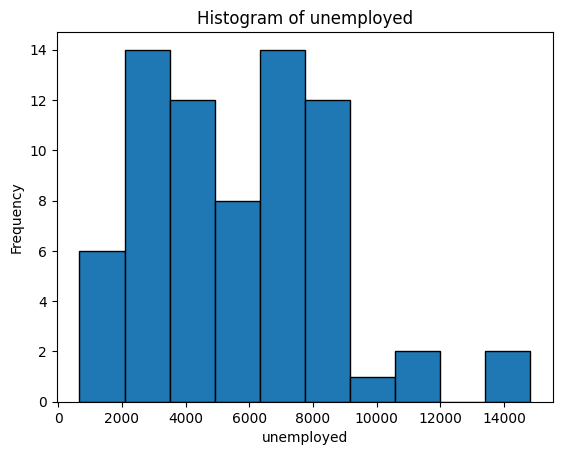

In [19]:
column_to_analyze = 'unemployed'
plt.hist(data[column_to_analyze], bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

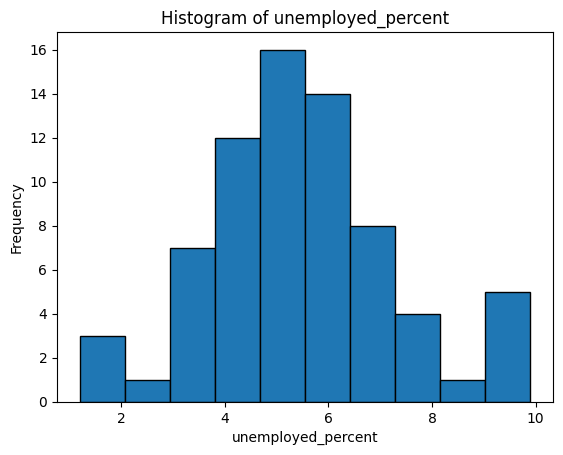

In [20]:
column_to_analyze = 'unemployed_percent'
plt.hist(data[column_to_analyze], bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

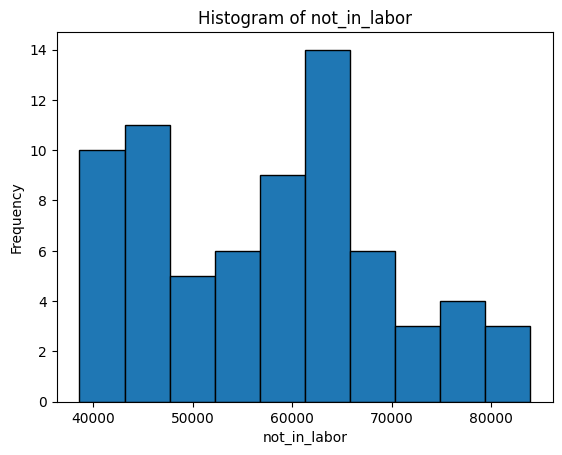

In [21]:
column_to_analyze = 'not_in_labor'
plt.hist(data[column_to_analyze], bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

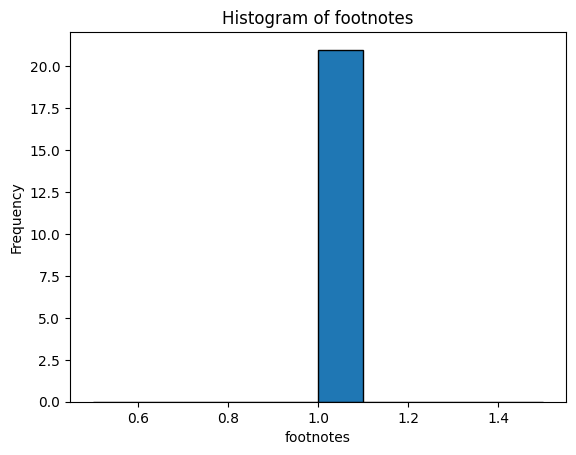

In [22]:
column_to_analyze = 'footnotes'
plt.hist(data[column_to_analyze], bins=10, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('{}'.format(column_to_analyze))
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(column_to_analyze))
plt.show()

# Data Preprocessing

Fixing the typo agrictulture_ratio

In [23]:
data.rename(columns={'agrictulture_ratio': 'agriculture_ratio'}, inplace=True)
data.head()

,year,population,labor_force,population_percent,employed_total,employed_percent,agriculture_ratio,nonagriculture_ratio,unemployed,unemployed_percent,not_in_labor,footnotes
0,1941,99900,55910,56.0,50350,50.4,9100,41250,5560,9.9,43990,NaN
1,1942,98640,56410,57.2,53750,54.5,9250,44500,2660,4.7,42230,NaN
2,1943,94640,55540,58.7,54470,57.6,9080,45390,1070,1.9,39100,NaN
3,1944,93220,54630,58.6,53960,57.9,8950,45010,670,1.2,38590,NaN
4,1945,94090,53860,57.2,52820,56.1,8580,44240,1040,1.9,40230,NaN


# Data Analysis

### 1. US Population, total Employment, and total Unemployment throughout the year.

C:\Users\Eugene Winata\AppData\Local\Temp\ipykernel_18240\1694127570.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data['year'], data['average_employed'], 'r-', label='average_employed', linestyle = '--')
C:\Users\Eugene Winata\AppData\Local\Temp\ipykernel_18240\1694127570.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data['year'], data['average_unemployed'], 'g-', label='average_unemployed',linestyle = '--')
C:\Users\Eugene Winata\AppData\Local\Temp\ipykernel_18240\1694127570.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data['year'], data['average_population'], 'b-', la

Text(0.5, 1.0, 'US Population, total Employment, and total Unemployment throughout the year')

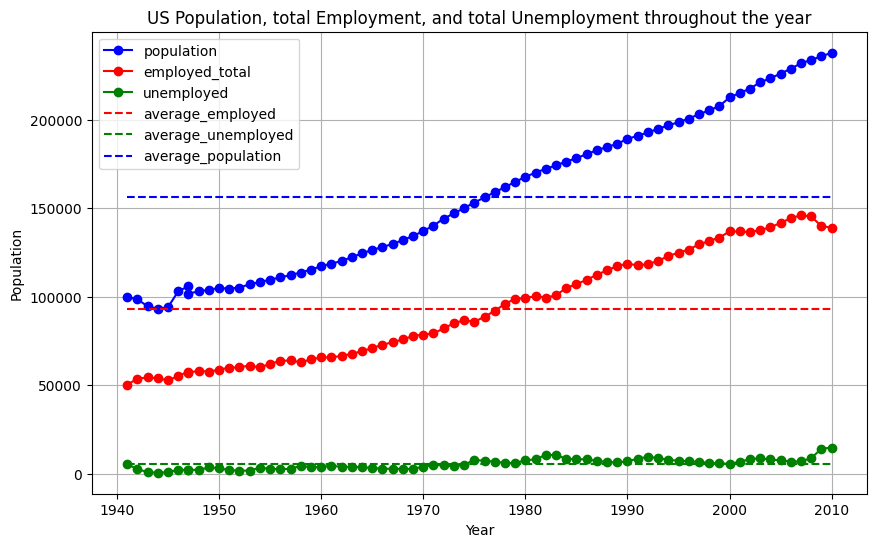

In [24]:
plt.figure(figsize=(10,6))
data['average_employed'] = data['employed_total'].mean()
data['average_unemployed'] = data['unemployed'].mean()
data['average_population'] = data['population'].mean()

plt.plot(data['year'], data['population'], 'b-', label='population', marker = 'o')
plt.plot(data['year'], data['employed_total'], 'r-', label='employed_total', marker = 'o')
plt.plot(data['year'], data['unemployed'], 'g-', label='unemployed', marker = 'o')
plt.plot(data['year'], data['average_employed'], 'r-', label='average_employed', linestyle = '--')
plt.plot(data['year'], data['average_unemployed'], 'g-', label='average_unemployed',linestyle = '--')
plt.plot(data['year'], data['average_population'], 'b-', label='average_population',linestyle = '--')

plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='upper left')
plt.grid(True)
plt.title('US Population, total Employment, and total Unemployment throughout the year')

As we can see from the plot above, the total employment is steadily increasing throughout the year, following the increase of the population. However we can also see that the increase in population does not exactly match the increased in employment as we can see a drop of employed in the year 2010. Meanwhile the level of unemployed seems to stay low throughout the year although it shows a slight increase starting from 1970 with the largest jump in 2010.

### 2. Force Labor Composition in the US

#### 2.1 Average Force Labor composition


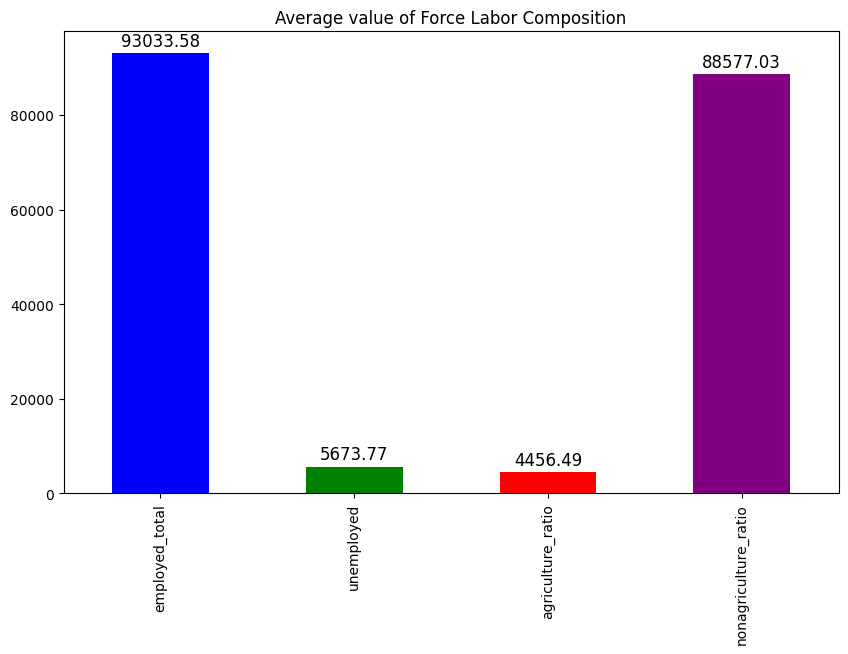

In [25]:
average_data = data.mean()

ax = average_data[['employed_total', 'unemployed', 'agriculture_ratio', 'nonagriculture_ratio']].plot(kind='bar', 
figsize=(10, 6), color = ['blue', 'green', 'red', 'purple'])

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 9), 
                textcoords='offset points')
plt.title('Average value of Force Labor Composition')
plt.show()

#### 2.2 Employment Composition throughout the year

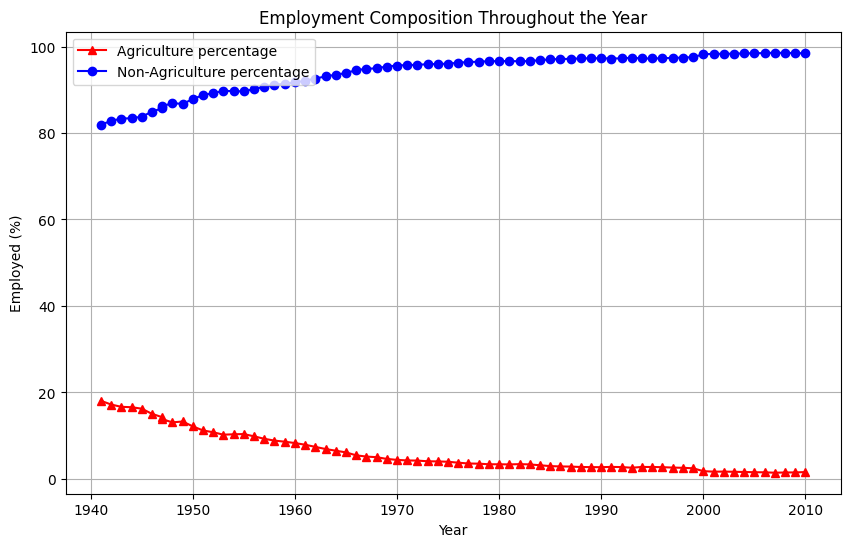

In [26]:
data['agriculture_ratio_rate'] = (data['agriculture_ratio'] / data['employed_total']) * 100
data['non_agriculture_ratio_rate'] = (data['nonagriculture_ratio'] / data['employed_total']) * 100
plt.figure(figsize=(10,6))
plt.plot(data['year'], data['agriculture_ratio_rate'], 'r-',label = 'Agriculture percentage',marker = '^')
plt.plot(data['year'], data['non_agriculture_ratio_rate'], 'b-',label = 'Non-Agriculture percentage',marker = 'o')

plt.title('Employment Composition Throughout the Year')
plt.xlabel('Year')
plt.ylabel('Employed (%)')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

As seen from the plot above, we can see the decline of interest in the agriculture field where it started from roughly 18% of the employed to just around 1 or 2%. Meanwhile the interest in non-agriculture field has been increasing in contrast.

### 3. Footnotes Analysis

In [27]:
footnotes_df = data[data['footnotes']==1]
footnotes_df.describe()


,year,population,labor_force,population_percent,employed_total,employed_percent,agriculture_ratio,nonagriculture_ratio,unemployed,unemployed_percent,not_in_labor,footnotes,average_employed,average_unemployed,average_population,agriculture_ratio_rate,non_agriculture_ratio_rate
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0,2.100000e+01,2.100000e+01,21.000000,21.000000,21.000000
mean,1991.142857,191978.190476,124891.523810,64.514286,117774.714286,60.895238,3181.047619,114593.619048,7116.857143,5.585714,67086.523810,1.0,9.303358e+04,5.673775e+03,156272.521127,3.236027,96.763900
std,17.788439,42436.257856,31280.608731,2.947590,29160.380342,2.907830,1153.559512,30200.645097,3054.797167,1.559258,11465.462623,0.0,1.491128e-11,1.863909e-12,0.000000,2.458280,2.458467
min,1953.000000,107056.000000,63015.000000,58.800000,61179.000000,55.500000,2095.000000,54919.000000,1834.000000,2.900000,44041.000000,1.0,9.303358e+04,5.673775e+03,156272.521127,1.434470,89.767731
25%,1978.000000,161910.000000,102250.000000,63.200000,96048.000000,58.500000,2206.000000,92661.000000,5692.000000,4.600000,59659.000000,1.0,9.303358e+04,5.673775e+03,156272.521127,1.586320,96.473638
50%,1998.000000,205220.000000,137673.000000,66.000000,131463.000000,62.300000,3223.000000,128085.000000,7001.000000,5.500000,67547.000000,1.0,9.303358e+04,5.673775e+03,156272.521127,2.569544,97.430456
75%,2005.000000,226082.000000,149320.000000,66.500000,139252.000000,63.000000,3409.000000,137020.000000,8149.000000,6.000000,76762.000000,1.0,9.303358e+04,5.673775e+03,156272.521127,3.526362,98.413680
max,2010.000000,237830.000000,154287.000000,67.100000,146047.000000,64.400000,6260.000000,143952.000000,14825.000000,9.600000,83941.000000,1.0,9.303358e+04,5.673775e+03,156272.521127,10.232269,98.565530


### 4. Labor Force Participant Rate

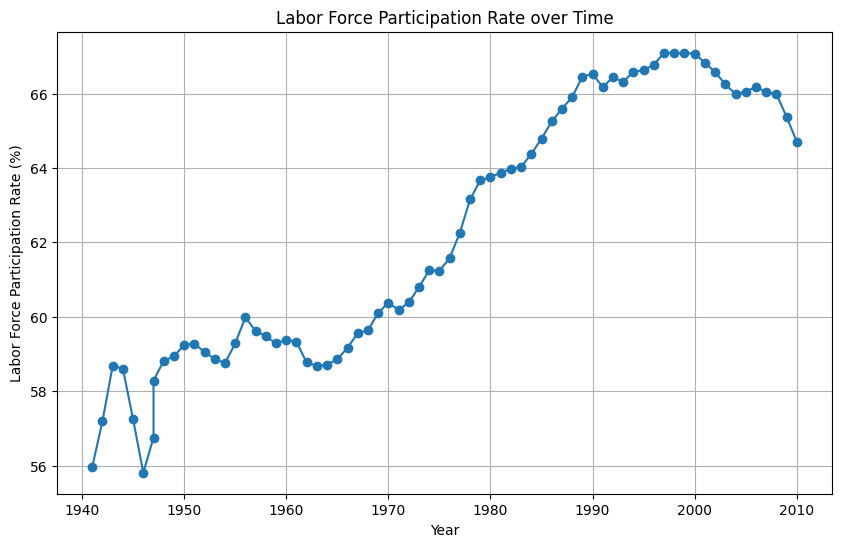

In [28]:
data['labor_force_participation_rate'] = (data['labor_force'] / data['population']) * 100

plt.figure(figsize=(10,6))
plt.plot(data['year'], data['labor_force_participation_rate'], marker = 'o', linestyle = '-')

plt.title('Labor Force Participation Rate over Time')
plt.xlabel('Year')
plt.ylabel('Labor Force Participation Rate (%)')
plt.grid(True)

plt.show()

As seen from the chart above, the percentage of the labor force seems to be increasing per population throughout the year with the all time high at around 67% of the population. 

### Predictive Model

#### Employed Prediction

c:\Users\Eugene Winata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


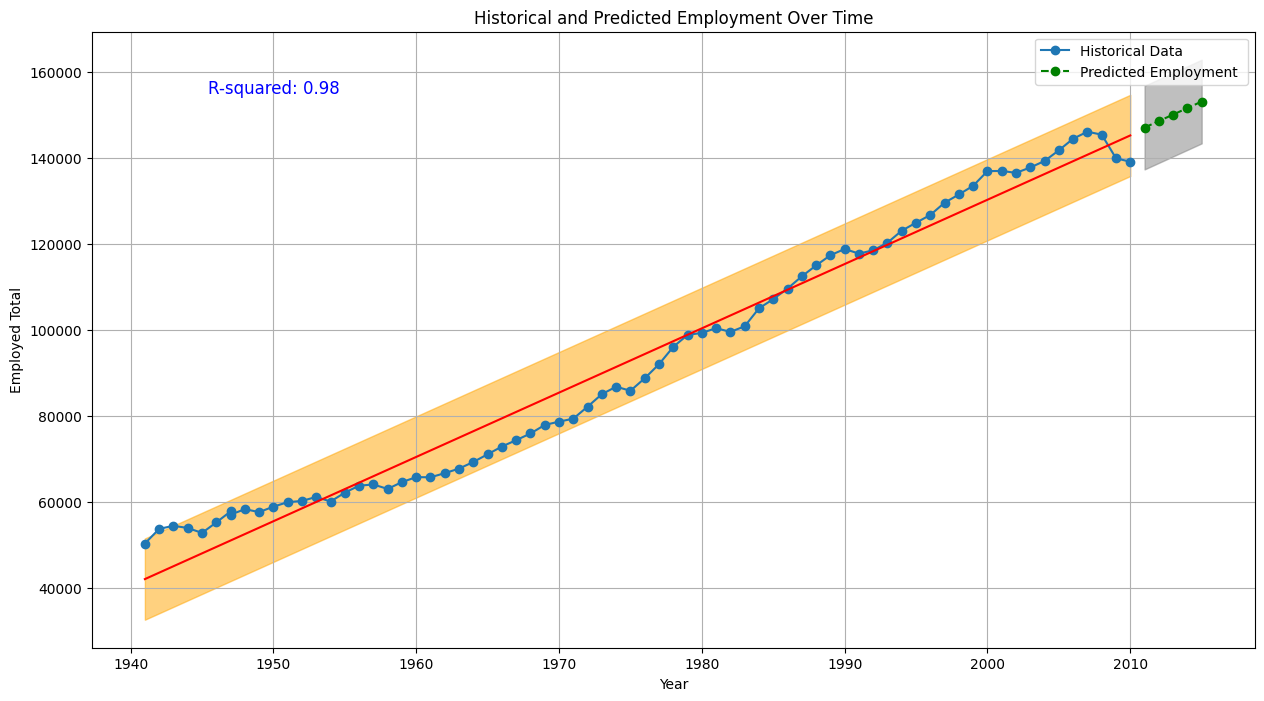

In [29]:
x = data[['year']]
y = data['employed_total']

# split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# set the train model
model = LinearRegression()
model.fit(x_train, y_train)

# predict employment
future_years = np.array([max(data['year']) + i for i in range(1, 6)]).reshape(-1, 1)
future_predictions = model.predict(future_years)

# interval
mse = mean_squared_error(y_test, model.predict(x_test))
confidence_interval = 1.96 * sqrt(mse)

lower_bound = future_predictions - confidence_interval
upper_bound = future_predictions + confidence_interval

# linear regression
model_all_data = LinearRegression()
model_all_data.fit(x, y)

# interval
mse_all_data = mean_squared_error(y, model_all_data.predict(x))
confidence_interval_all_data = 1.96 * sqrt(mse_all_data)

lower_bound_all_data = model_all_data.predict(x) - confidence_interval_all_data
upper_bound_all_data = model_all_data.predict(x) + confidence_interval_all_data

r_squared = r2_score(y, model_all_data.predict(x))
plt.figure(figsize=(15, 8))
plt.plot(data['year'], data['employed_total'], marker='o', linestyle='-', label='Historical Data')
plt.plot(future_years, future_predictions, marker='o', linestyle='--', color='g', label='Predicted Employment ')
plt.fill_between(future_years.flatten(), lower_bound, upper_bound, color='gray', alpha=0.5)
plt.plot(x, model_all_data.predict(x), color='r')
plt.fill_between(x['year'], lower_bound_all_data, upper_bound_all_data, color='orange', alpha=0.5)
plt.title('Historical and Predicted Employment Over Time')
plt.xlabel('Year')
plt.ylabel('Employed Total')
plt.grid(True)
plt.legend()

# Display the R-squared as text on the plot
plt.text(0.1, 0.9, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.show()


#### Unemployed Prediction

c:\Users\Eugene Winata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


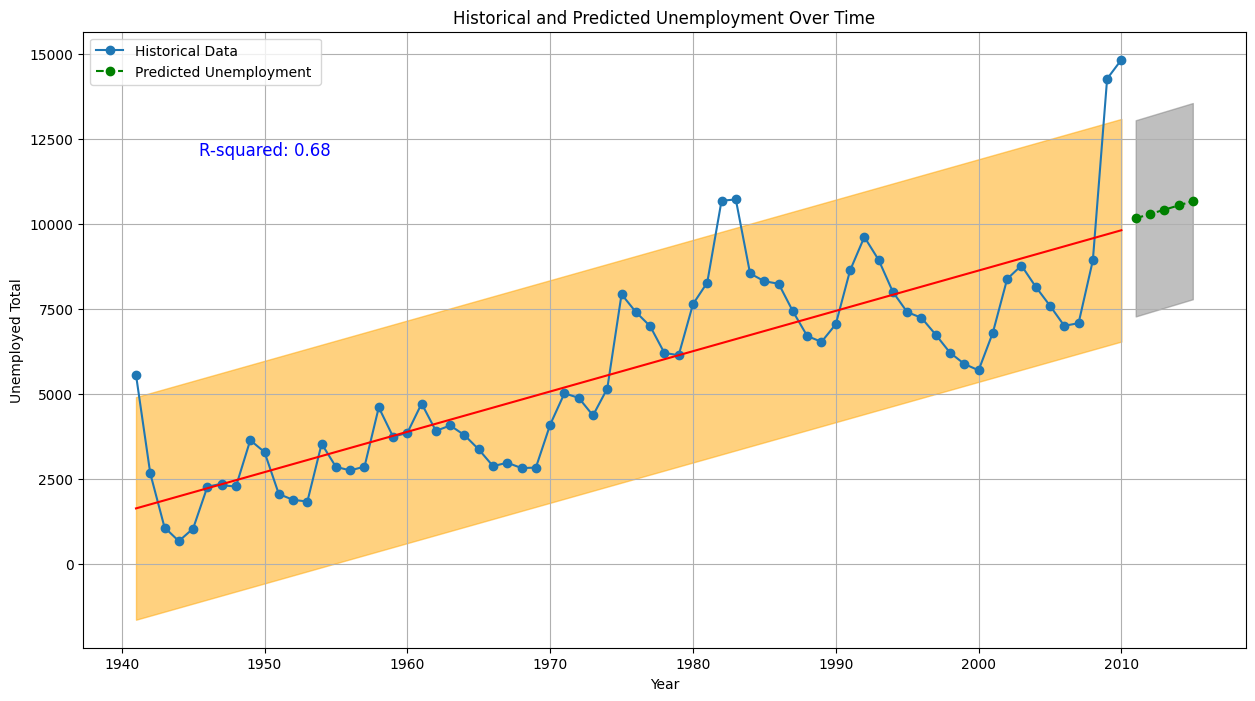

In [30]:
x = data[['year']]
y = data['unemployed']

# split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# set the train model
model = LinearRegression()
model.fit(x_train, y_train)

# predict employment
future_years = np.array([max(data['year']) + i for i in range(1, 6)]).reshape(-1, 1)
future_predictions = model.predict(future_years)

# interval
mse = mean_squared_error(y_test, model.predict(x_test))
confidence_interval = 1.96 * sqrt(mse)

lower_bound = future_predictions - confidence_interval
upper_bound = future_predictions + confidence_interval

# linear regression
model_all_data = LinearRegression()
model_all_data.fit(x, y)

# interval
mse_all_data = mean_squared_error(y, model_all_data.predict(x))
confidence_interval_all_data = 1.96 * sqrt(mse_all_data)

lower_bound_all_data = model_all_data.predict(x) - confidence_interval_all_data
upper_bound_all_data = model_all_data.predict(x) + confidence_interval_all_data

r_squared = r2_score(y, model_all_data.predict(x))
plt.figure(figsize=(15, 8))
plt.plot(data['year'], data['unemployed'], marker='o', linestyle='-', label='Historical Data')
plt.plot(future_years, future_predictions, marker='o', linestyle='--', color='g', label='Predicted Unemployment ')
plt.fill_between(future_years.flatten(), lower_bound, upper_bound, color='gray', alpha=0.5)
plt.plot(x, model_all_data.predict(x), color='r')
plt.fill_between(x['year'], lower_bound_all_data, upper_bound_all_data, color='orange', alpha=0.5)
plt.title('Historical and Predicted Unemployment Over Time')
plt.xlabel('Year')
plt.ylabel('Unemployed Total')
plt.grid(True)
plt.legend()

# Display the R-squared as text on the plot
plt.text(0.1, 0.8, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.show()


### Pre and Post Recession Analysis

#### Employment Pattern

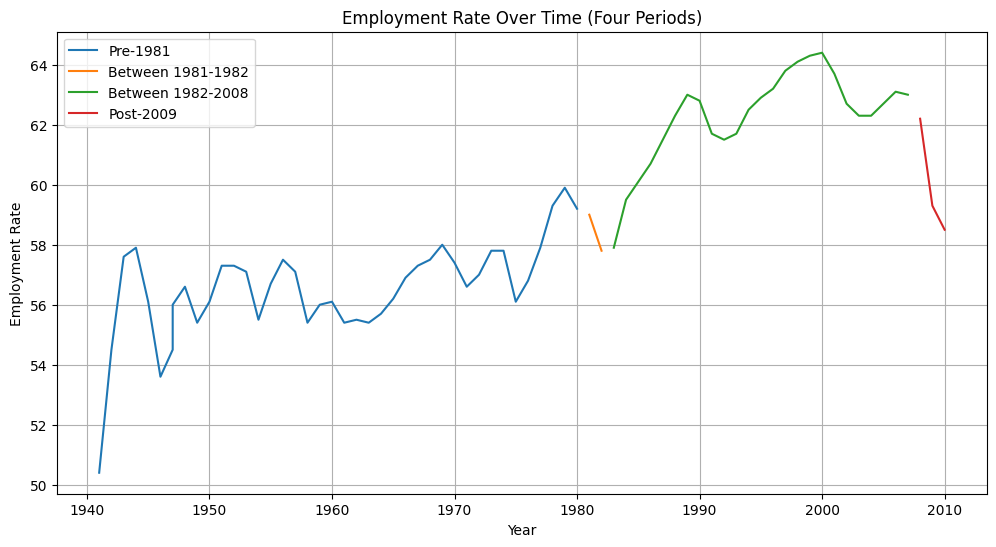

In [31]:
recession1_start_year = 1981
recession1_end_year = 1982
recession2_start_year = 2008
recession2_end_year = 2009

pre_1981_mask = (data['year'] < recession1_start_year)
between_1981_1982_mask = ((data['year'] >= recession1_start_year) & (data['year'] <= recession1_end_year))
between_1982_2008_mask = ((data['year'] > recession1_end_year) & (data['year'] < recession2_start_year))
post_2009_mask = (data['year'] >= recession2_start_year)

pre_1981_data = data[pre_1981_mask]
between_1981_1982_data = data[between_1981_1982_mask]
between_1982_2008_data = data[between_1982_2008_mask]
post_2009_data = data[post_2009_mask]

plt.figure(figsize=(12, 6))
plt.plot(pre_1981_data['year'], pre_1981_data['employed_percent'], label='Pre-1981')
plt.plot(between_1981_1982_data['year'], between_1981_1982_data['employed_percent'], label='Between 1981-1982')
plt.plot(between_1982_2008_data['year'], between_1982_2008_data['employed_percent'], label='Between 1982-2008')
plt.plot(post_2009_data['year'], post_2009_data['employed_percent'], label='Post-2009')

plt.title('Employment Rate Over Time (Four Periods)')
plt.xlabel('Year')
plt.ylabel('Employment Rate')
plt.grid(True)
plt.legend()
plt.show()

#### Unemployment Pattern

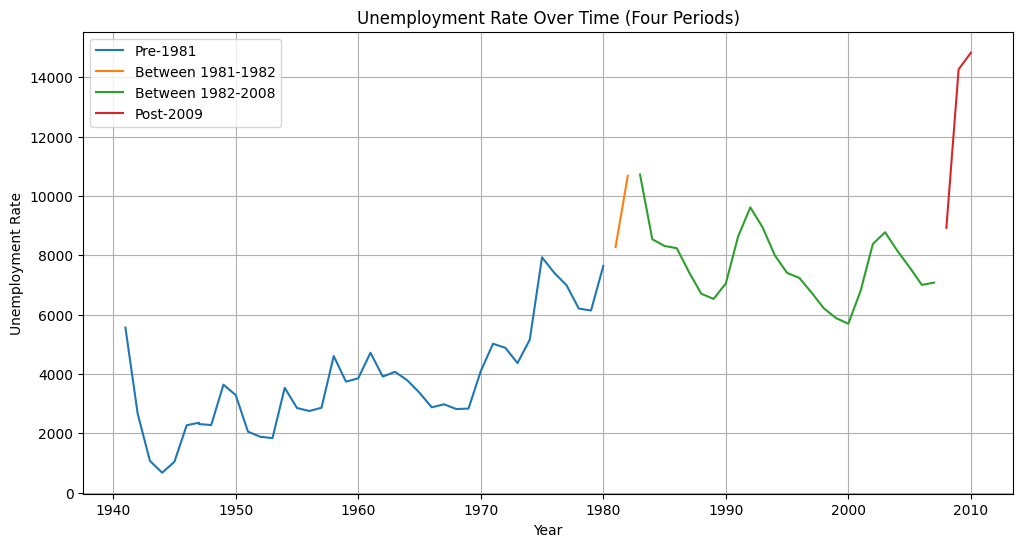

In [32]:
recession1_start_year = 1981
recession1_end_year = 1982
recession2_start_year = 2008
recession2_end_year = 2009

pre_1981_mask = (data['year'] < recession1_start_year)
between_1981_1982_mask = ((data['year'] >= recession1_start_year) & (data['year'] <= recession1_end_year))
between_1982_2008_mask = ((data['year'] > recession1_end_year) & (data['year'] < recession2_start_year))
post_2009_mask = (data['year'] >= recession2_start_year)

pre_1981_data = data[pre_1981_mask]
between_1981_1982_data = data[between_1981_1982_mask]
between_1982_2008_data = data[between_1982_2008_mask]
post_2009_data = data[post_2009_mask]

plt.figure(figsize=(12, 6))
plt.plot(pre_1981_data['year'], pre_1981_data['unemployed'], label='Pre-1981')
plt.plot(between_1981_1982_data['year'], between_1981_1982_data['unemployed'], label='Between 1981-1982')
plt.plot(between_1982_2008_data['year'], between_1982_2008_data['unemployed'], label='Between 1982-2008')
plt.plot(post_2009_data['year'], post_2009_data['unemployed'], label='Post-2009')

plt.title('Unemployment Rate Over Time (Four Periods)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.legend()
plt.show()